# Data Story

In this section, I present a preliminary exploration of data. We begin with the data <i>csv</i> file, which was obtained after the data wrangling section. The major objective of this section is to understand the general trends in the data, and gain some quick insights and relation between variables that will help buiding up the statistical model. 

In [1]:
# Import necessary Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from pandas.plotting import autocorrelation_plot

In [2]:
# Load the cleaned csv data as DataFrame
df = pd.read_csv('G:\Capstone2\Intermediate_data\Trimmed.csv',
                 parse_dates=['earliest_cr_line', 'issue_d',
                              'last_pymnt_d', 'last_credit_pull_d'])

# drop unnecessary column
df.drop('Unnamed: 0', axis=1, inplace=True)

C:\Users\lnp2\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## How is the company doing? What needs improvement? 

Lending club began its service in 2007 and it gained popularity quickly after it showed up in the market. The major indicator of the club's business is the amount funded to the borrowers, which has increased logarithmatically over time. In 2007, the club funded only a couple of hundred thousands dollors to the borrowers, which became in the order of several millions in 2016. 

In average, 85% of customer pay the loans in time. The remaining customers make late payments or are charged off. The charged off loans goes through the loan collections and some of that is recovered with a late fee. The company seeks to reduce the fraction of late/charged off payments. But  Over the years, the fraction of customers (and charged off amount) has not improved. 

Understanding the risk of loans and the classifying the borrowers based on their credit history is a useful step in improving the fraction of Late/charged off borrowers. This project focusses on estimating the risk of loans and provide suggestions to minimize the amount of loans that carries high risk.  

C:\Users\lnp2\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


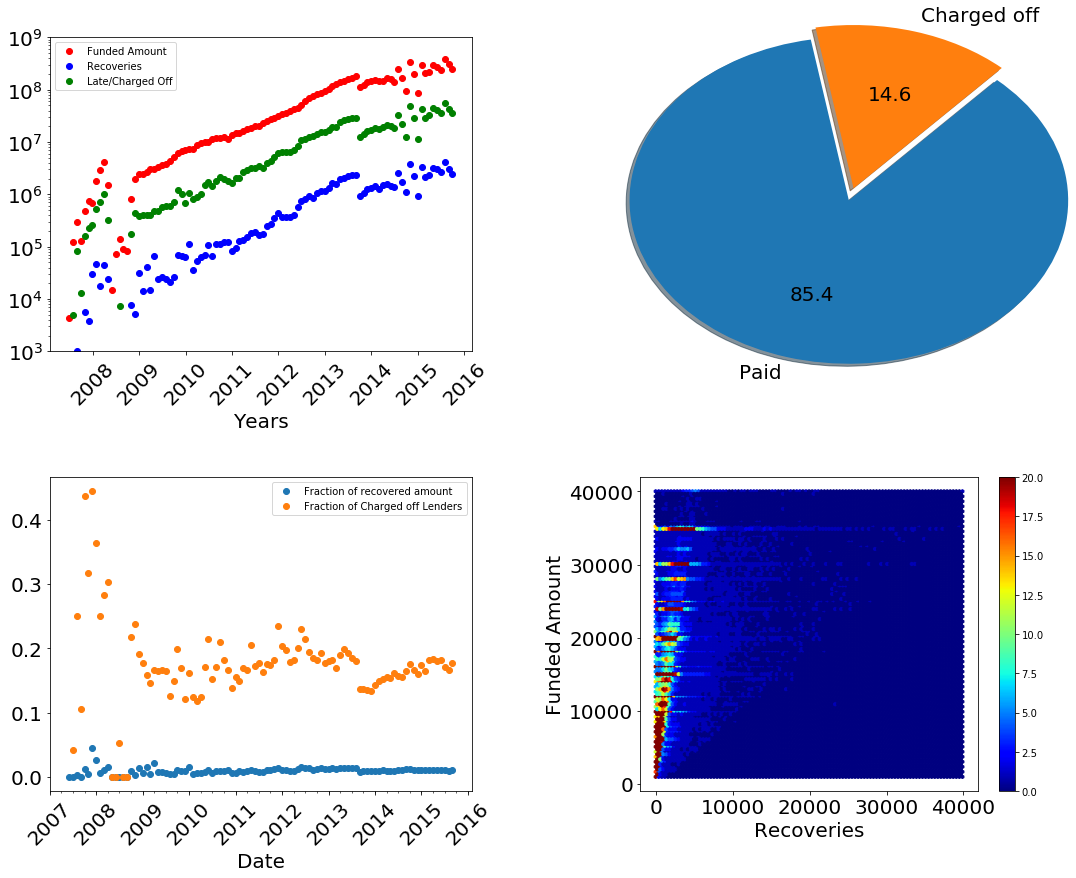

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=[15, 12])

df_sample = df[['issue_d', 'term', 'funded_amnt', 'recoveries', 'loan_status']]

df_sample.final_d = df_sample.issue_d +\
                    pd.to_timedelta(df_sample.term, unit='M')

df_sample = df_sample[df_sample.final_d < df_sample.issue_d.max()]

df_sample.index = df_sample.issue_d

df_sam = df_sample.resample('M')

# Subplot I

plt.subplot(axes[0, 0])
plt.plot(df_sam.funded_amnt.sum(), 'ro', label='Funded Amount')
plt.plot(df_sam.recoveries.sum(), 'bo', label='Recoveries')
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=20)
axes[0, 0].tick_params(axis='y', rotation=0, labelsize=20)

# Subplot II

S2 = df_sample.groupby('loan_status').count().\
               term.plot(kind='pie', autopct='%.1f', startangle=100,
                         explode=(0.05, 0.05), labels=('Paid', 'Charged off'),
                         shadow=True, radius=1.3, rotatelabels=False,
                         fontsize=20, ax=axes[0, 1])

S2.set(ylabel='')

# Subplot III
(df_sam.sum().recoveries/df_sam.sum().
    funded_amnt).plot(marker='o', ax=axes[1, 0],
                      label='Fraction of recovered amount',
                      linewidth=0.0)

df_sam1 = (df_sample[df_sample.loan_status == 'Current/Fully Paid']).\
           resample('M').count()
df_sam2 = (df_sample[df_sample.loan_status != 'Current/Fully Paid']).\
           resample('M').count()

(df_sam2.term/df_sam1.term).plot(ax=axes[1, 0], linewidth=0.0, marker='o',
                                 label='Fraction of Charged off borrowers')
axes[1, 0].legend()

axes[1, 0].tick_params(labelsize=20)
axes[1, 0].set_xlabel('Date', fontsize=20)
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=20)


df_b = df_sample.loan_status != 'Current/Fully Paid'
df_sam = df_sample[df_b]
df_sam = df_sam.resample('M')

plt.plot(df_sam.sum().funded_amnt, 'go', label='Late/Charged Off')

plt.semilogy()
plt.ylim(1e3, 1e9)
plt.xlabel('Years', fontsize=20)
plt.legend()

# Subplot IV
ax = plt.subplot(2, 2, 4)
df_sample = df[df.recoveries > 0]
plt.hexbin(df_sample.recoveries, df_sample.funded_amnt,
           cmap='jet', bins=200, vmax=20)

cax = plt.colorbar()

ax.set_xlabel('Recoveries', fontsize=20)
ax.set_ylabel('Funded Amount', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
plt.tight_layout()

plt.subplots_adjust(hspace=0.4, wspace=0.4)

del df_b, df_sample, df_sam, S2, df_sam1, df_sam2

## How much investment next year?

The amount invested to the borrowers increased in logarithmic rate until mid-2015. After then, the growth slows down. This growth can not be correctly modeled by a linear function. Since the growth is logarithmic, we should model the growth with a polynomial of logarithmic time. The best description is given by three order polynomial (the first and second order polynomial give huge bias). Using this model, we predict that the company needs to collect investment of three hundred million in the next year.

To verify the logarithmic growth model, we use the autocorrelation function analysis. This gives information on how two variables are correlated. Here, we are looking for the correlation of the company's growth with time variable. Autocorrelation of (+1) means both variables are strongly correlated and change in a similar way, i.e., if the independent variable (time in this case) increases, the dependent variable (Investment required) also increases. Autocorrelation of zero means that there is no correlation. Negative autocorrelation means that the dependent variable decreases with an independent variable.

In the plot below (right), we find that the logarithmic value of investment positively correlated with time until 2012 and remains roughly unchanged (zero correlation). In 2015, the investment is negatively correlated, which again increases after 2015. 

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


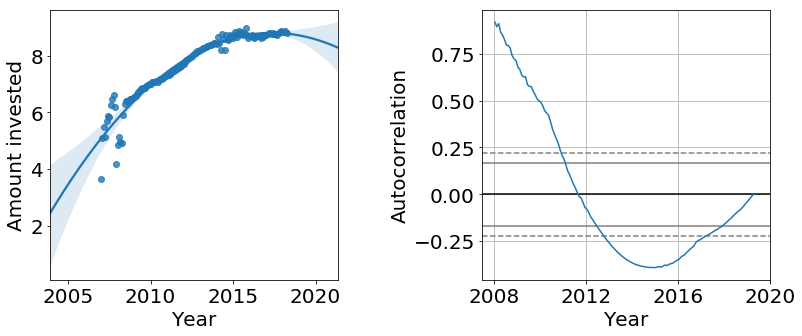

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=[10, 5])

df_sample = df[['issue_d', 'funded_amnt', 'recoveries']]
df_sample.index = df_sample.issue_d
df_sam = df_sample.resample('M').sum()

df_sam = df_sam[df_sam['funded_amnt'] > 0]
df_sam['amount_log'] = np.log10(df_sam.funded_amnt)
df_sam['year_of_business'] = 2007 + (df_sam.index -
                                     df_sam.index.min()).days/365

plt.subplot(position=[0.1, 0.15, 0.4, 0.75])
S1 = sns.regplot(data=df_sam, x='year_of_business', order=3,
                 y='amount_log')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Amount invested', fontsize=20)
plt.axis(fontsize=20)
plt.grid(True, which='minor')
S1.tick_params(labelsize=20)

S2 = autocorrelation_plot(df_sam.funded_amnt, ax=axes[0, 1])
S2.set_position([0.7, 0.15, 0.4, 0.75])
S2.set_ylabel('Autocorrelation', fontsize=20)
S2.set_xlabel('Year', fontsize=20)

S2.set_xticks(np.arange(0.5, 150, 48))
desired_ticks = (S2.get_xticks()/12 + 2008).astype(int)
S2.set_xticklabels(desired_ticks, fontsize=20, rotation=0)
S2.tick_params(labelsize=20)

del S1, S2, df_sam, df_sample

## Who are the customers?

Understanding the existing customer's financial problems is useful information in making future policy. It is also in the interest of the club to identify the potential customers in the future. 

Our analysis shows that most of the customers are the middle class people having an annual income less than a hundred thousand and their credit balance in the order of a few times their current annual income. Most of the borrowers borrow funds for debt consolidation and credit card payments. This indicates that most of the customers are already having a type of financial management problem.

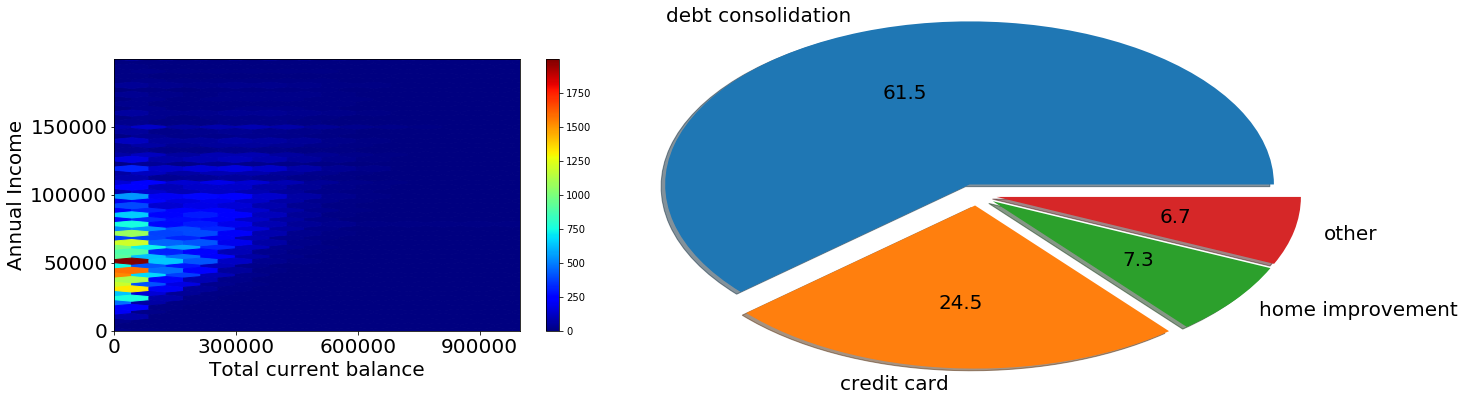

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False)

S1 = plt.subplot(121)
S1.figsize = (5, 5)

plt.hexbin(df.tot_cur_bal, df.annual_inc, bins=2000, cmap='jet')
plt.xlim(0, 1e6)
plt.ylim(0, 2e5)

plt.xticks(np.arange(0, 1e6, 3e5), fontsize=20)
plt.yticks(np.arange(0, 2e5, 5e4), fontsize=20)

plt.xlabel('Total current balance', fontsize=20)
plt.ylabel('Annual Income', fontsize=20)
plt.colorbar()

df.purpose = df.purpose.str.replace('_', ' ')
df_sample = df.groupby('purpose').count().\
            sort_values(by='term', ascending=False)[:4]
S2 = df_sample.term.plot(kind='pie', autopct='%.1f', startangle=0,
                         shadow=True, radius=1.5,
                         explode=(0.1, 0.1, 0.1, 0.1),
                         rotatelabels=False, fontsize=20,
                         figsize=(20, 5), ax=axes[0, 1])

S2.set(ylabel='')
plt.show()

del S2, df_sample, S1

## Distribution of borrowers?

Lending club issues the loans to the borrowers whose income is not verified. But in the past years, those borrowers did not get higher loans -- their distribution is centered around an average of 15,000. 

There is no difference between the distribution of loan amount between 'good' (those who pays loans in time) and 'bad' (Late/charged off payers) borrowers. This means that both categories on average get the same amount of loans. In order to stop giving high loans to bad borrowers, we first need to identify good and bad borrowers. 

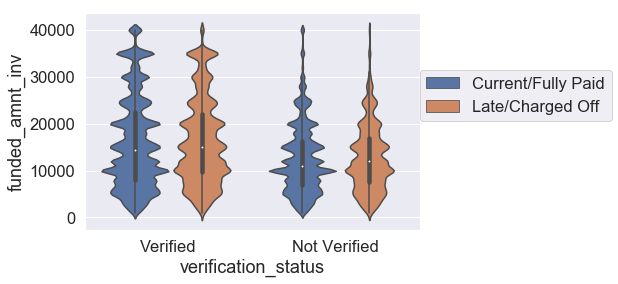

In [6]:
df_sample = df.copy()
sns.set(font_scale=1.5)

ax = sns.violinplot(data=df_sample, x='verification_status',
                    y='funded_amnt_inv', hue='loan_status')

ax.legend(loc=(1, 0.5))

del df_sample

## What determines the loan status?

Before we start making a model, it is useful to identify important features in the data. This helps our analysis in two ways: First, it will identify the important features that we can utilize in the feature selection in our statistical model. Second, it gives a rough idea of which variables are more important to predict the loan status. To understand the correlation between loan status with other features of the data, we did a quick preliminary survey on the relation between loan status and remaining features. It shows that <i>account opened in the past two years</i> is the most important feature to consider. Some selected features that have a high correlation with the loan status is below. 

In general, the credit score (like FICO) depends heavily on the length of the credit history. However, our analysis shows that the length of long credit history is less important compared to recent credit history. As shown in the chart below, the fifteen most important variables that determine the loan stats represent either the most recent (within 2 years) credit history of the borrowers or the other current features of the loans. While this method we are using below is a rough approach, we follow up the reliability of this method later.



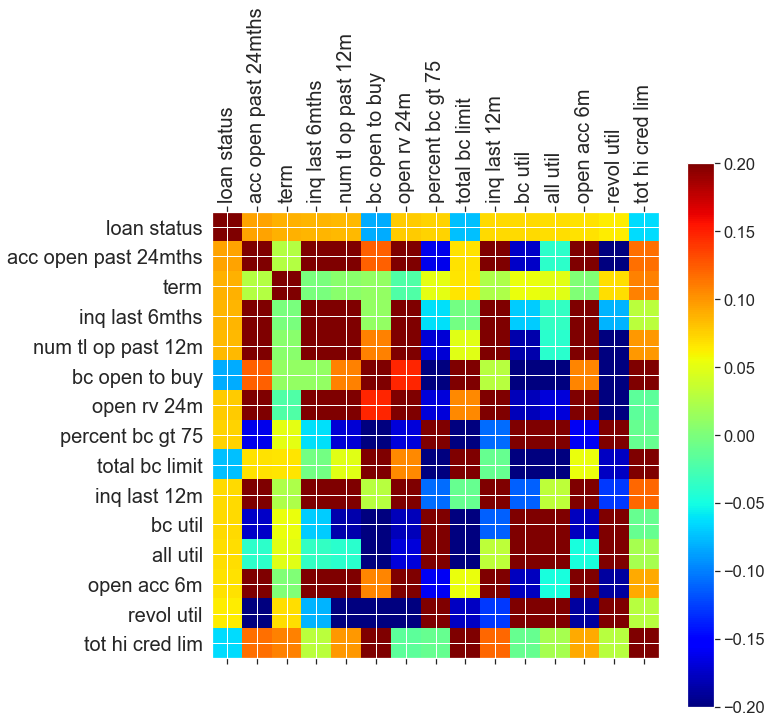

In [7]:
df_copy = df.copy(deep=False)

# Delete columns that already tells the loan status

df_copy.drop(['last_pymnt_amnt', 'collection_recovery_fee',
              'recoveries', 'out_prncp_inv', 'out_prncp',
              'total_rec_prncp', 'int_rate', 'total_pymnt',
              'total_pymnt_inv', 'total_rec_late_fee',
              'total_rec_int', 'emp_title', 'debt_settlement_flag',
              'addr_state', 'purpose', 'delinq_amnt', 'hardship_flag',
              'pymnt_plan', 'collections_12_mths_ex_med',
              'chargeoff_within_12_mths', 'acc_now_delinq'],
             axis=1, inplace=True)

df_copy.loan_status = pd.get_dummies(df_copy.loan_status, drop_first=True)

corr_mat = df_copy.corr()

# Select the most relevant columns
rel_ind = list((abs(corr_mat.loan_status).
                sort_values(ascending=False)[:15]).index)

cor_mat = corr_mat.loc[rel_ind, rel_ind]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cor_mat, cmap='jet', vmin=-0.2, vmax=0.2)
plt.colorbar(mappable=cax)

ax.set_xticks(np.arange(0, 15, 1))
ax.set_yticks(np.arange(0, 15, 1))

rel_ind = [rel.replace('_', ' ') for rel in rel_ind]

ax.set_xticklabels(rel_ind, rotation=90, fontsize=20)
ax.set_yticklabels(rel_ind, rotation=0, fontsize=20)

plt.show()

del df_copy, cor_mat, corr_mat

## Role of recent history? 

The credit history of borrowers tells a lot on the risk of the loan. As expected, borrowers with better credit conditions are more likely to pay the loans. For example, the open to buy ratio (The difference between the credit limit assigned to a cardholder account and the present balance on the account) have a significantly smaller risk. The borrowers with more accounts open in past years or inquiries are less likely to pay the loans in time. The error bars represent 99.99% confidence interval. 

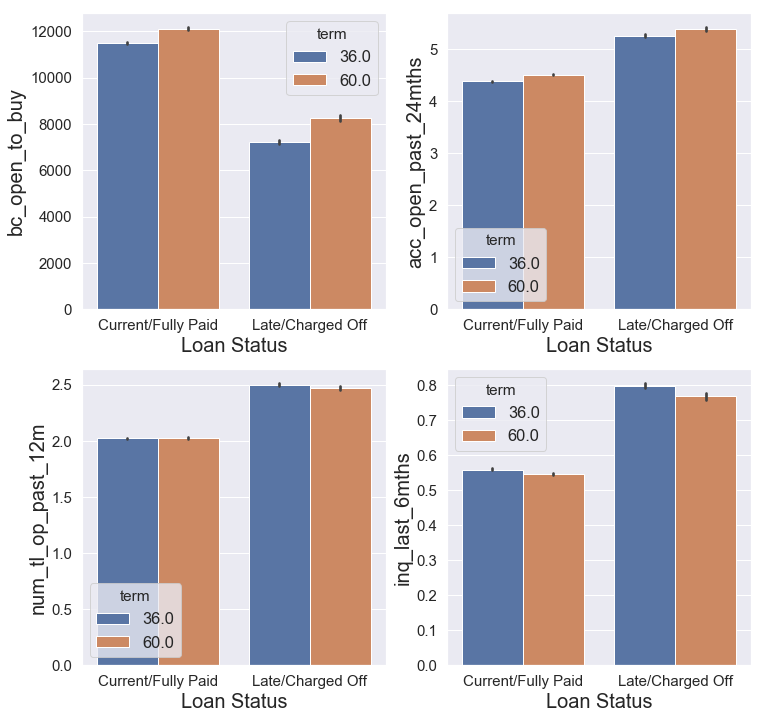

In [8]:
df_sample = df.copy(deep=False)

fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12, 12))

g = sns.barplot(x='loan_status', y='bc_open_to_buy', hue='term',
                ci=99.99, data=df_sample, ax=axes[0, 0])

g = sns.barplot(x='loan_status', y='acc_open_past_24mths', hue='term',
                ci=99.99, data=df_sample, ax=axes[0, 1])

g = sns.barplot(x='loan_status', y='num_tl_op_past_12m', hue='term',
                ci=99.99, data=df_sample, ax=axes[1, 0])

g = sns.barplot(x='loan_status', y='inq_last_6mths', hue='term',
                ci=99.99, data=df_sample, ax=axes[1, 1])

for i in range(2):
    for j in range(2):
        axes[i, j].tick_params(labelsize=15)
        axes[i, j].set_xlabel('Loan Status', fontsize=20)
        axes[i, j].set_ylabel(axes[i, j].get_ylabel(), fontsize=20)

del df_sample, g

## Role of credit history?

The long-term credit history has a marginal effect on the risk compared to the recent history of borrowers. Below are the histograms or Kernel density Estimation plots of some of the features. Borrowers having lower credit history have only slightly more risk compared to those who have a long credit history. The annual income does not make much difference in the risk factor. This is because the real income can be different since not all borrowers are show verified income. But the DTI (A ratio of the borrowers total monthly debt to the total debt obligations), which reflects the current financial condition of borrowers makes more contribution to the risk factor. borrowers with lower DTI are more likely to pay the loans in time.  This attests that the conclusion we made in the above section is correct. 

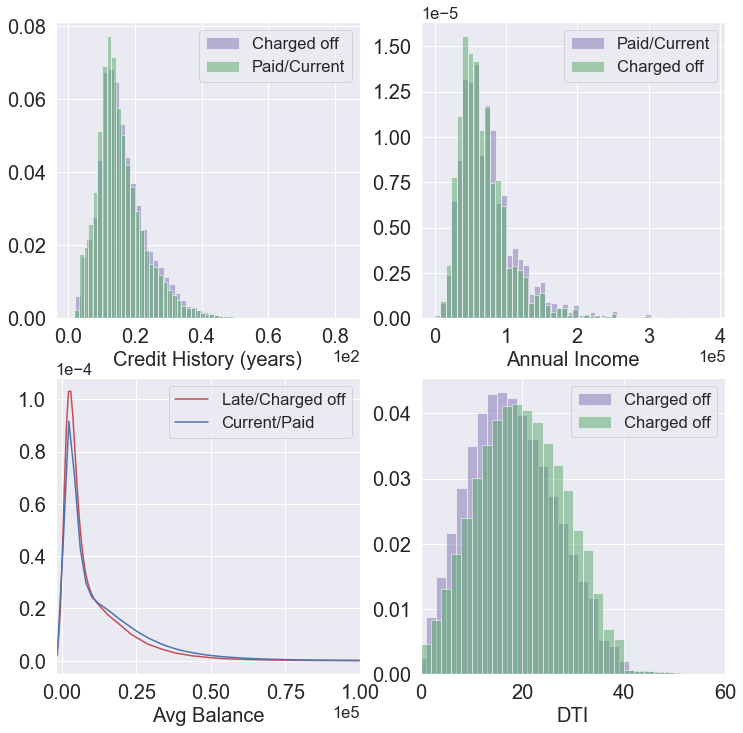

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12, 12))

# Subplot I

df['history'] = ((df.issue_d - df.earliest_cr_line).dt.days/365)

df_sample1 = df[df.loan_status == 'Current/Fully Paid']
S1 = df_sample1.history.hist(bins=50, alpha=0.5, color='m', ax=axes[0, 0],
                             density=True, label='Charged off')

df_sample2 = df[df.loan_status != 'Current/Fully Paid']
df_sample2.history.hist(bins=50, alpha=0.5, color='g', ax=S1,
                        density=True, label='Paid/Current')
plt.xlim(0, 55)
S1.set_xlabel('Credit History (years)', fontsize=20)
S1.ticklabel_format(style='sci', axis='both', scilimits=(-5, 0))
S1.legend()
S1.tick_params(labelsize=20)

# Subplot II
S2 = df_sample1.annual_inc.hist(bins=50, alpha=0.5, ax=axes[0, 1],
                                color='m', density=True, label='Paid/Current')

df_sample2.annual_inc.hist(bins=50, alpha=0.5, ax=S2,
                           color='g', density=True, label='Charged off')
plt.xlim(0, 2.5e5)
S2.legend()
S2.ticklabel_format(style='sci', axis='both', scilimits=(-5, 5))
S2.set_xlabel('Annual Income', fontsize=20)
S2.tick_params(labelsize=20)

# Subplot III

df_sample = df.copy(deep=False)

df1 = df_sample[df_sample.loan_status != 'Current/Fully Paid']
ax = df1.avg_cur_bal.plot.kde(color='r', ax=axes[1, 0],
                              label='Late/Charged off')

df2 = df_sample[df_sample.loan_status == 'Current/Fully Paid']
df2.avg_cur_bal.plot.kde(color='b', ax=ax, label='Current/Paid')
ax.set_xlim(-2e3, 1e5)

ax.legend(loc='best')
ax.set_xlabel('Avg Balance', fontsize=20)
ax.set_ylabel('', fontsize=20)
ax.ticklabel_format(style='sci', axis='both', scilimits=(-6, -5))
ax.tick_params(labelsize=20)

# Subplot IV
df_sample1.dti.hist(bins=500, alpha=0.5, color='m', ax=axes[1, 1],
                    density=True, label='Charged off')
df_sample2.dti.hist(bins=500, alpha=0.5, color='g', ax=axes[1, 1],
                    density=True, label='Charged off')
plt.xlim(0, 60)
axes[1, 1].set_xlabel('DTI', fontsize=20)
axes[1, 1].tick_params(labelsize=20)
axes[1, 1].legend(loc='best')

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

del df_sample, df_sample1, df_sample2

## When people stop paying ?

There is a high density of borrowers that stop paying the loan after one year of the loan issued. This trend is independent of whether the loan term is three or five years. This means that the risk of loan increases until it reaches up to year and then falls down over time. 

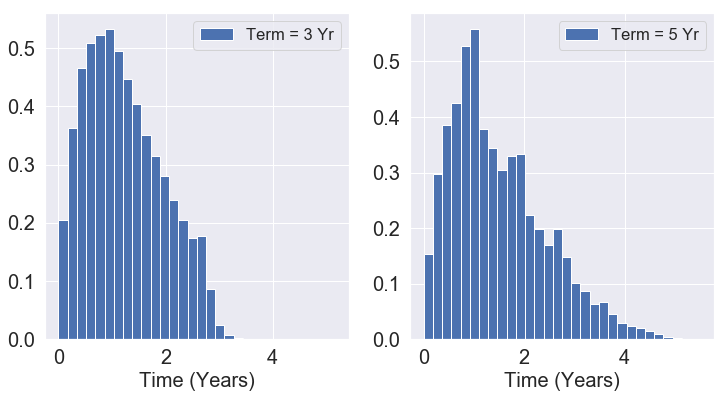

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(12, 6))

df_sample = df[(df.loan_status == 'Late/Charged Off') &
               (df.term == 36)]

duration = ((df_sample.last_pymnt_d - df_sample.issue_d)
            .dropna().dt.days/(1*365))
duration.hist(bins=30, density=True, ax=axes[0, 0], label='Term = 3 Yr')

df_sample = df[(df.loan_status == 'Late/Charged Off') &
               (df.term == 60)]

duration = ((df_sample.last_pymnt_d - df_sample.issue_d)
            .dropna().dt.days/(1*365))
duration.hist(bins=30, density=True, ax=axes[0, 1], label='Term = 5 Yr')

for i in range(2):
    axes[0, i].set_xlabel('Time (Years)', fontsize=20)
    axes[0, i].tick_params(labelsize=20)
    axes[0, i].legend()

del df_sample, duration

## What is the best loan amount?

Here, we have used average of Loan status as a risk factor (The loan status is 1 for Late/charged off borrowers and 0 for current/paid borrowers). The five year loan term has double the risk of three year loan term. For all categories of loan amount, five year loan have almost 50 percent more chance of being unpaid/charged off. The risk does not change much with the loan amount itself. 

The risk also depend on the purpose of the loans. Loans for small business and education have much higher risk compared to other categories. 

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


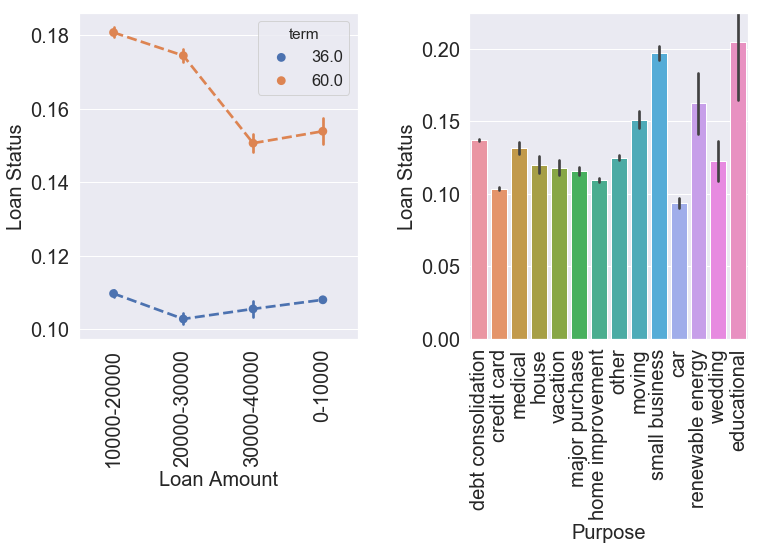

In [11]:
df['loan_status_dum'] = pd.get_dummies(df.loan_status, drop_first=True)

fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=[12, 6])

# Subplot I
loan_amnt_copy = df['loan_amnt'].copy(deep=False)

loani = 0
step = 10000
while loani <= df.loan_amnt.max():
    cond1 = df.loan_amnt <= (loani + step)
    cond2 = df.loan_amnt > loani
    cond = cond1 & cond2
    lekh_str = str(loani) + '-' + str(loani + step)
    loan_amnt_copy.where(~cond, lekh_str, inplace=True)
    loani = loani + step

df['loan_amnt_cp'] = loan_amnt_copy

df_sample = df[['loan_amnt_cp', 'loan_status_dum', 'term']]
ax = sns.pointplot(data=df_sample, x='loan_amnt_cp', y='loan_status_dum',
                   hue='term', estimator=np.mean, ax=axes[0, 0],
                   linestyles='--')
ax.tick_params(labelsize=20)
ax.set_xlabel('Loan Amount', fontsize=20)
ax.set_ylabel('Loan Status', fontsize=20)
ax.tick_params(axis='x', rotation=90, labelsize=20)

# Subplot II

df_sample = df[['loan_amnt_cp', 'loan_status_dum', 'purpose']]
ax = sns.barplot(data=df_sample, x='purpose', y='loan_status_dum',
                 estimator=np.mean, ax=axes[0, 1])

ax.set_ylim(0.00, 0.225)
ax.tick_params(axis='x', rotation=90, labelsize=20)
ax.tick_params(labelsize=20)
ax.set_xlabel('Purpose', fontsize=20)
ax.set_ylabel('Loan Status', fontsize=20)

ax.tick_params(axis='x', rotation=90, labelsize=20)
plt.subplots_adjust(wspace=0.4)

del loani, loan_amnt_copy, df_sample